In [2]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float, Int
import matplotlib.pyplot as plt

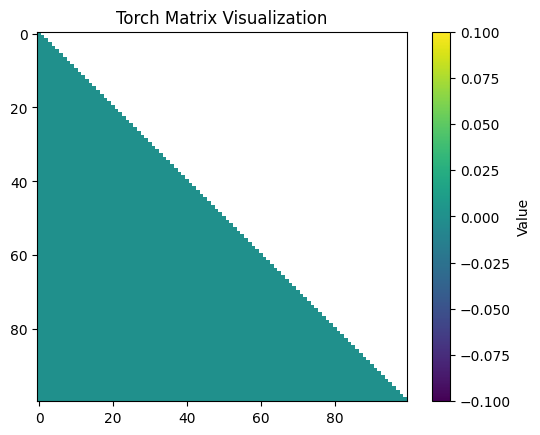

In [3]:






def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
    mask = torch.zeros(n_context, n_context)
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf')
    
    return mask



# Create a random 5x5 matrix
M = create_mask(100)

# Convert to NumPy for visualization
M_np = M.numpy()

# Plot the matrix
plt.imshow(M_np, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Torch Matrix Visualization")
plt.show()

In [ ]:
@dataclass
class GPTConfig:
	d_vocab: int = 10_000
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	act_fn: type[nn.Module] = nn.ReLU

# note: the residual stream is `n_context` by `d_model`

# this is the row-wise (last dimension) softmax of x
# F.softmax(x, dim=-1)

class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_O = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head)
		

		raise NotImplementedError()

	def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		#hidden = self.embedding(x)
		
		attn_scores = self.W_K(x).T
		attn_scores = x @ self.W_Q(attn_scores)

		n_context = x.size(0)
		casual_mask = torch.tril(torch.ones(n_context, n_context, device=x.device))
		attn_scores = attn_scores.masked_fill(casual_mask = 0, float('-inf'))

		attn_scores = F.softmax(attn_scores)
		
		attn_scores = F.softmax(attn_scores)

		attn_next = x @ W_V @ W_O.T


		raise NotImplementedError()


class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		raise NotImplementedError()
		# uses `AttentionHead`

	def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		raise NotImplementedError()




class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		raise NotImplementedError()

	def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		raise NotImplementedError()



class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		raise NotImplementedError()
		# uses `MultiHeadedAttention` and `MLP`
		# uses nn.Embedding for the embedding, transpose of it for the unembedding

	def forward(x: Int[torch.Tensor, "n_context"]) -> Float[torch.Tensor, "n_context d_vocab"]:
		raise NotImplementedError()